# Exploration of earthquake damage in Nepal

In this notebook the dataset provided by drivendata.org is scientifically explored. This dataset is provided as a part of the "Richter's Predictor: Modeling Earthquake Damage" competition that can be found under the following URL: https://www.drivendata.org/competitions/57/nepal-earthquake/

Our goal is to predict the damage grade on a score of three by analysing features of the building.

### Preliminaries

Importing the required dependencies.

In [1]:
# enables referencing modules in repository
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from src.features import build_features
# from src.data import make_dataset 
# commented out because: there seems to be an issue at the moment with the initial method from make_dataset
from src.models import train_model
from src.models import predict_model
from src.visualization import visualize

Loading the data.

In [2]:
train_df = pd.read_csv('../data/raw/train_values.csv')
target_df = pd.read_csv('../data/raw/train_labels.csv')

### General Properties

Let us get a first overview of the dataset.

In [3]:
print('number of rows:', len(train_df))
print('number of columns:', len(train_df.columns))

number of rows: 260601
number of columns: 39


In [4]:
pd.options.display.max_columns = None
train_df.head(10)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
5,333020,8,558,6089,2,10,9,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
6,728451,9,475,12066,2,25,3,4,n,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
7,475515,20,323,12236,2,0,8,6,t,w,q,v,x,s,u,0,0,0,0,0,1,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
8,441126,0,757,7219,2,15,8,6,t,r,q,f,q,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
9,989500,26,886,994,1,0,13,4,t,i,n,v,j,s,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [6]:
train_df.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,2.606010e+05,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,5.256755e+05,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,0.018235,0.068154,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,0.983949,0.111880,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,3.045450e+05,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,0.133800,0.252010,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,0.418389,0.315219,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.611900e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.257570e+05,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.897620e+05,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We have a dataset with 260601 rows and 39 features. These features contain both numerical and categorical data. The categorical data in turn can be divided into binary (True/False) and multiclass features.
- numerical: `building_id`, `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id`, `count_floors_pre_eq`, `age`, `area_percentage`, `height_percentage`, `count_families`
- binary: `has_superstructure...`, `has_secondary_use...`
- multiclass: `land_surface_condition`, `foundation_type`, `roof_type`, `ground_floor_type`, `other_floor_type`, `position`, `plan_configuration`, `legal_ownership_status`

## Feature Description
---
In the following the features of the dataset are described. This is done by evaluating the name, datatype and values of the feature to try to predict its usage. Deeper analysis for each feature is further described after the following list:

1. `building_id` seems to be used to identify each unique building.
2. `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id` these features seem to describe the location the building is located in.
3. `count_floors_pre_eq` seems to be the number of floors the building had before the earthquake happend
4. `age` seems to be the age of the building before it was destroyed
5. `area_percentage` maybe the amount of buildings in an area 
6. `height_percentage` likely the height of the building before it was destroyed
7. `land_surface_condition` likely the condition the surface of the ground of the building had before the earthquake
8. `foundation_type` as the name suggests this seems to be the type of the foundation the building was built 
9. `roof_type`, `ground_floor_type`, `other_floor_type` as the name suggest this seems to be the type of the roof and floors the building had. It seems like only to types of floors where recorded
10. `position` (unkown)
11. `plan_configuration` likely class of building structure
12. `has_superstructure..` likely a one hot encoded feature that represents the type of used superstructure
13. `legal_ownership_status` likely who the building belongs to
14. `count_families` seems to be the amount of families that lived in the building
15. `has_secondary_use..` seems to be a describe wether the building had an additional purpose than living in it


## 1. Analysis for `building_id`
---
This feature describes each unique building that was recorded in the dataset. As the data shows, a total of 260.601 (about a quarter of a million) buildings where recorded in this dataset. As this feature only describes a number that is unique to each building, no further analysis is conducted here as no more information gain is expected.

In [7]:
train_df.building_id.count()

260601

## 2. Analysis for `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id`
---
These features seem to describe the location the building is located in. It could be that 
* geo_level_1_id represents the region in which the building is located.
* geo_level_2_id represents the municipality in which the building is located.
* geo_level_3_id represents the specific area within the municipality in which the building is located.

Summary of the analysis below:
* Some regions have a high count with more than 15.000 recorded buildings while most regions have below 5000 recorded buildings.
* Region 17 has by far the highest amount of damage grade 3 buildings. It seems to be a the epicenter of the earthquake

In [8]:
geo_level_columns = [
    'geo_level_1_id',
    'geo_level_2_id',
    'geo_level_3_id'
]

train_df[geo_level_columns].head(10)

,geo_level_1_id,geo_level_2_id,geo_level_3_id
0,6,487,12198
1,8,900,2812
2,21,363,8973
3,22,418,10694
4,11,131,1488
5,8,558,6089
6,9,475,12066
7,20,323,12236
8,0,757,7219
9,26,886,994


### Distribution
The geo_level feature describes for each unique building where it is located. Let's see how the buildings are distributed for the highest level.

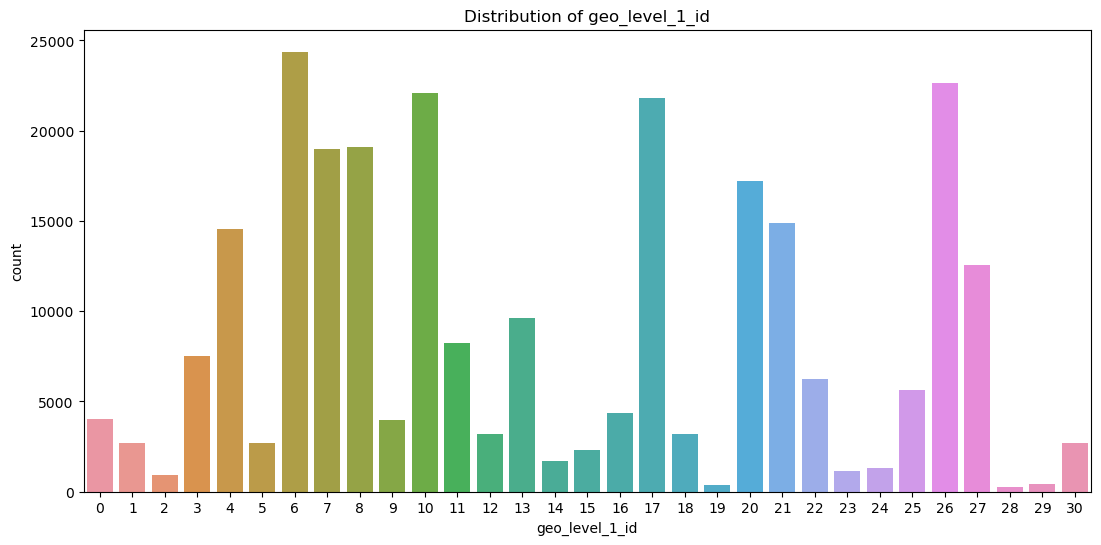

In [9]:
plt.figure(figsize=(13,6))
sns.countplot(data=train_df, x='geo_level_1_id')
plt.title("Distribution of geo_level_1_id")
plt.show()


In the graph above we can see the distribution of the region each recorded building is located at. Some regions have a high count with more than 15.000 recorded buildings while most regions have below 5000 recorded buildings.

### Relation to target value


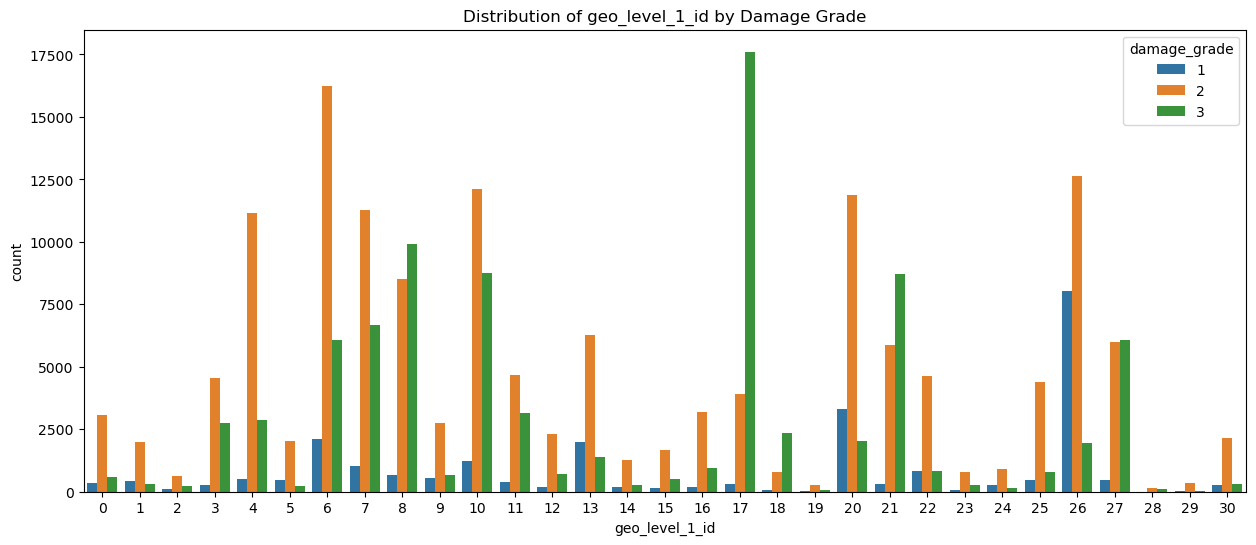

In [10]:
# merge the two dataframes on building_id
merged_df = pd.merge(train_df, target_df, on='building_id')
plt.figure(figsize=(15,6))
sns.countplot(data=merged_df, x="geo_level_1_id", hue="damage_grade")
plt.title("Distribution of geo_level_1_id by Damage Grade")
plt.show()

The graph shows that region 17 seems to have had the most significant earthquake impact. The propability of damage grade 3 is very high if a building belongs to this region.

In [11]:
# create a crosstab of variable1 and variable2
cross_tab = pd.crosstab(merged_df['geo_level_1_id'], merged_df['damage_grade'])

# perform chi-square test of independence
chi2, p, dof, expected = chi2_contingency(cross_tab)

# round p to 4 decimal places
rounded_p = round(p, 9)

print(f"The p value is: {rounded_p:.9f}")
print(f"The chi squared value is: {chi2}")

The p value is: 0.000000000
The chi squared value is: 72583.39892186754


According to the chi squared test of independence the geo_level_1_id variable is related to our target value.

## 3. Analysis for `count_floors_pre_eq`
---

The "count_floors_pre_eq" feature represents the number of floors in the building before the earthquake. 

### Distribution

Its possible values are integers from 1 to 9. The data is showing that most buildings had a height of 2 floors. The maximum size of a building has 9 floors.

In [12]:
train_df.count_floors_pre_eq.value_counts()

count_floors_pre_eq
2    156623
3     55617
1     40441
4      5424
5      2246
6       209
7        39
8         1
9         1
Name: count, dtype: int64

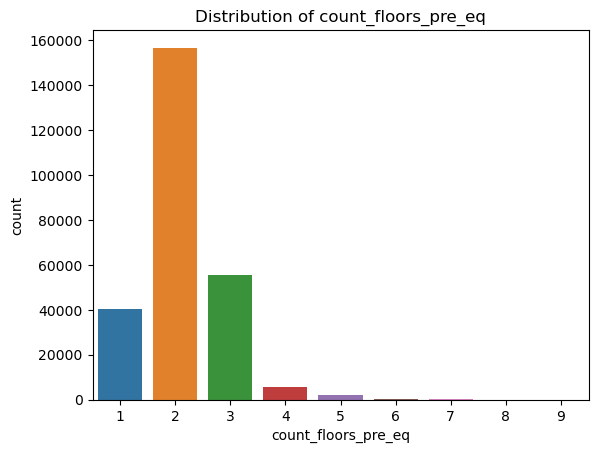

In [13]:
sns.countplot(data=train_df, x='count_floors_pre_eq')
plt.title("Distribution of count_floors_pre_eq")
plt.show()

The graph above shows that the feature is highly unbalanced.

### Relation to target value

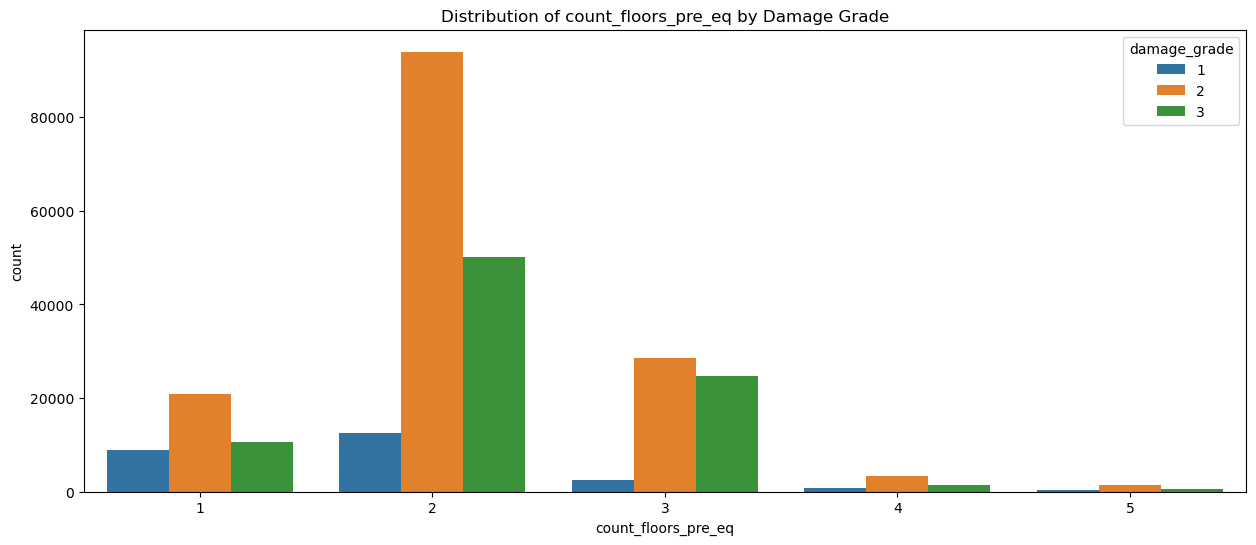

In [14]:
# merge the two dataframes on building_id
merged_df = pd.merge(train_df, target_df, on='building_id')
# as the data is unbalanced we only look at the values below 5 floors
filtered_df = merged_df.loc[merged_df['count_floors_pre_eq'] <= 5]
plt.figure(figsize=(15,6))
sns.countplot(data=filtered_df, x="count_floors_pre_eq", hue="damage_grade")
plt.title("Distribution of count_floors_pre_eq by Damage Grade")
plt.show()

The graph shows us that the damage distribution for each floor is similar. For each floor height the damage grade 1 has the lowest amount, the damage grade 2 the highest and damage grade 3 is in between or close to damage grade 2.

In [15]:
# create a crosstab of variable1 and variable2
cross_tab = pd.crosstab(filtered_df['count_floors_pre_eq'], filtered_df['damage_grade'])

# perform chi-square test of independence
chi2, p, dof, expected = chi2_contingency(cross_tab)

# round p to 4 decimal places
rounded_p = round(p, 9)

print(f"The p value is: {rounded_p:.9f}")
print(f"The chi squared value is: {chi2}")

The p value is: 0.000000000
The chi squared value is: 12270.099733468085


According to the chi squared test of independence the count_floors_pre_eq variable is related to our target value.

## 4. analysis for `age`
---
Summary of the analysis below:
1. The age feature is unbalanced with the age of the buildings going up to the maximum of age 995 years. However most buildings have an age below 40 years.
2. The exploration of the feature shows a trend regarding the damage grade type 1. The older the buildings are there is less damage of type 1. In fact for buildings that are older than 30 years damage of type 1 is no longer seen.
3. The age feature has no siginificant correlation to other features in the dataset


### Distribution

In [16]:
# lets see what the max value is
train_df.age.max()

995

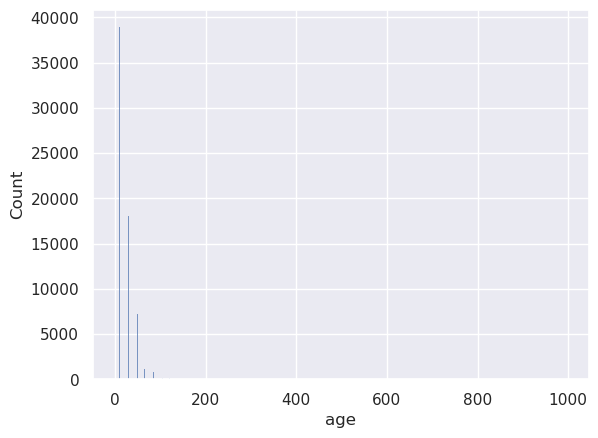

In [17]:
# Lets take a first look at the distribution
sns.set(style="darkgrid")
sns.histplot(train_df, x="age")
plt.show()

A first look at the distribution of the age value shows, that most buildings have an age below 200 years with a wide gap to some buildings that have about 900-1000 years. In the following we take a deeper look on the buildings below the age of 200 years as this part will propably be the most interesting for our prediction.

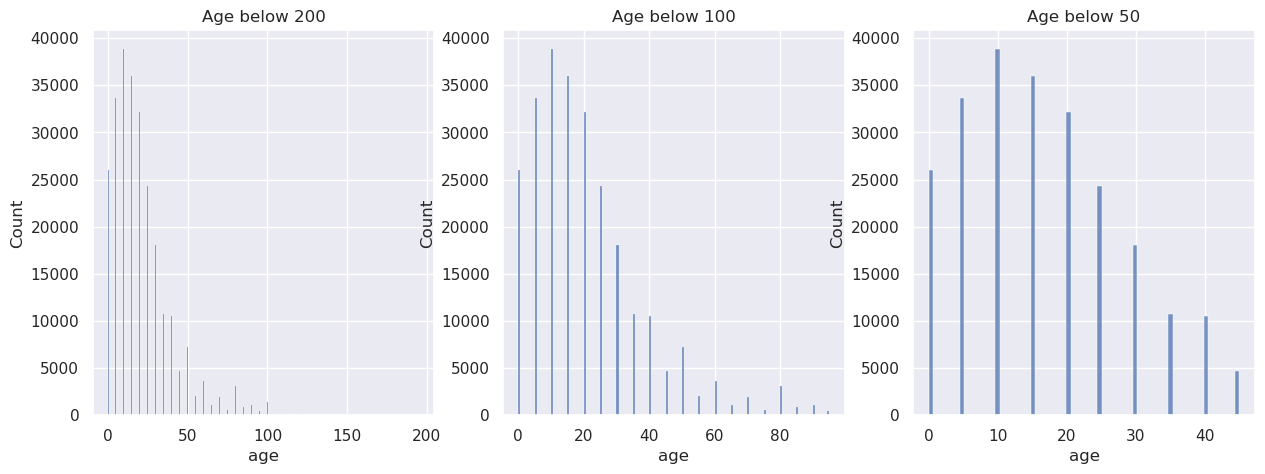

In [18]:
# as the graph shows most buildings are below the age of 200
# lets remove outliers and create a new graph

# merge the two dataframes on building_id
merged_df = pd.merge(train_df, target_df, on='building_id')

threshold1 = 200
threshold2 = 100
threshold3 = 50

temp_df1 = merged_df[merged_df['age'] < threshold1]
temp_df2 = merged_df[merged_df['age'] < threshold2]
temp_df3 = merged_df[merged_df['age'] < threshold3]

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first graph in the first subplot
sns.histplot(temp_df1['age'], ax=axs[0])
axs[0].set_title(f'Age below {threshold1}')

# Plot the second graph in the second subplot
sns.histplot(temp_df2['age'], ax=axs[1])
axs[1].set_title(f'Age below {threshold2}')

# Plot the third graph in the third subplot
sns.histplot(temp_df3['age'], ax=axs[2])
axs[2].set_title(f'Age below {threshold3}')

plt.show()

The graphs above show, that most recorded buildings had an age below 40 years.

### Relation to the target value
We now know the age most of the buildings in the dataset have. In the following the relation to the damage grade is analysed.

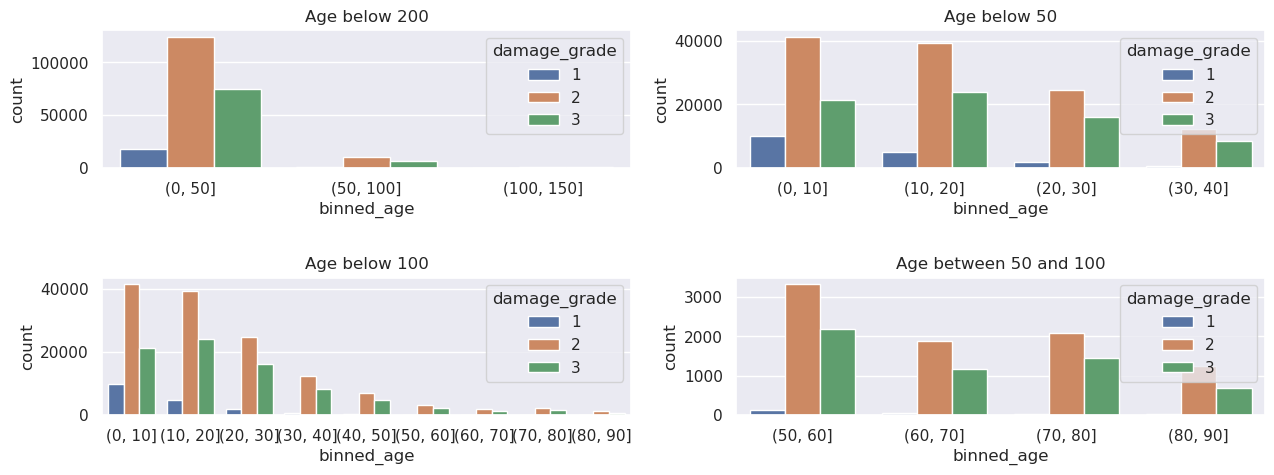

In [19]:
threshold1 = 200
threshold2 = 100
threshold3 = 50
threshold4 = 100

temp_df1 = merged_df.copy()
temp_df2 = merged_df.copy()
temp_df3 = merged_df.copy()
temp_df4 = merged_df.copy()

temp_df1["binned_age"] = pd.cut(merged_df['age'], bins=list(range(0,threshold1,50)))
temp_df2["binned_age"] = pd.cut(merged_df['age'], bins=list(range(0,threshold2,10)))
temp_df3["binned_age"] = pd.cut(merged_df['age'], bins=list(range(0,threshold3,10)))
temp_df4["binned_age"] = pd.cut(merged_df['age'], bins=list(range(50,threshold4,10)))

fig, axs = plt.subplots(2, 2, figsize=(15, 5))
# set the vertical spacing between the subplots
plt.subplots_adjust(hspace=0.8)

# Plot the first graph in the first subplot
sns.countplot(data=temp_df1, x='binned_age', hue='damage_grade', ax=axs[0][0])
axs[0][0].set_title(f'Age below {threshold1}')

# Plot the second graph in the second subplot
sns.countplot(data=temp_df2, x='binned_age', hue='damage_grade', ax=axs[1][0])
axs[1][0].set_title(f'Age below {threshold2}')

# Plot the third graph in the third subplot
sns.countplot(data=temp_df3, x='binned_age', hue='damage_grade', ax=axs[0][1])
axs[0][1].set_title(f'Age below {threshold3}')

# Plot the forth graph in the forth subplot
sns.countplot(data=temp_df4, x='binned_age', hue='damage_grade', ax=axs[1][1])
axs[1][1].set_title(f'Age between 50 and {threshold4}')

plt.show()

The graphs allow us to take a deeper look into the relation of the buildings age towards the damage grade it received from the earthquake. Interestingly there seems to be a trend with buildings that get older having a higher damage grade. In fact buildings that have an age above 30 years no longer have a damage grade of type 1 reported. (with the expection of some outliers at the age of 50 - 60 years).

### Relation to other features
As we can see in the analysis below. The age feature doesn't seem to have a relation to another feature in the dataset.

In [20]:
corr_matrix = merged_df.select_dtypes(include=[np.number]).corr()
corr_age = corr_matrix['age'].sort_values(ascending=False)
print(corr_age)

age                                       1.000000
count_floors_pre_eq                       0.086668
has_superstructure_mud_mortar_brick       0.079525
has_superstructure_adobe_mud              0.068032
height_percentage                         0.061074
damage_grade                              0.029273
geo_level_2_id                            0.012594
has_superstructure_stone_flag             0.009129
has_superstructure_timber                 0.005855
count_families                            0.005309
has_superstructure_mud_mortar_stone       0.001321
has_secondary_use_rental                  0.001193
has_secondary_use_use_police             -0.001195
building_id                              -0.001476
has_superstructure_other                 -0.001520
has_secondary_use_gov_office             -0.001764
has_secondary_use_health_post            -0.002169
has_secondary_use_agriculture            -0.002194
has_secondary_use_school                 -0.003514
has_secondary_use_industry     

## 5. Analysis for `area_percentage`

Summary: DESCRIPTION UNSURE The data contains many outliers above a value of 18. Most values are between 5 and 9. A correlation to the target value is almost nonexisting. 

### Distribution


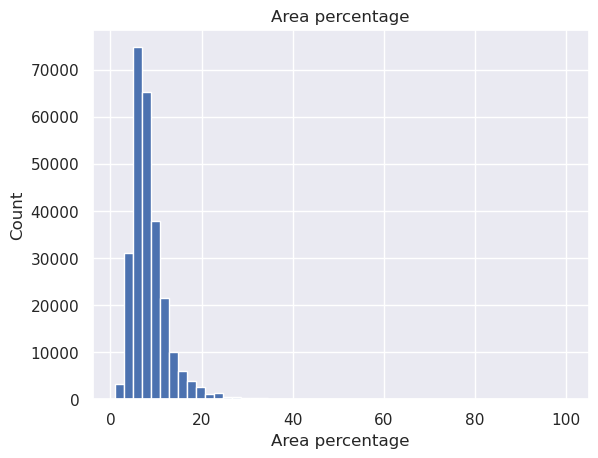

In [21]:
train_df['area_percentage'].hist(bins=50)
plt.title(f'Area percentage')
plt.xlabel('Area percentage')
plt.ylabel('Count')
plt.show()

The histogram is right-skewed, the data is not normally distributed.There may be outliers on the right side.

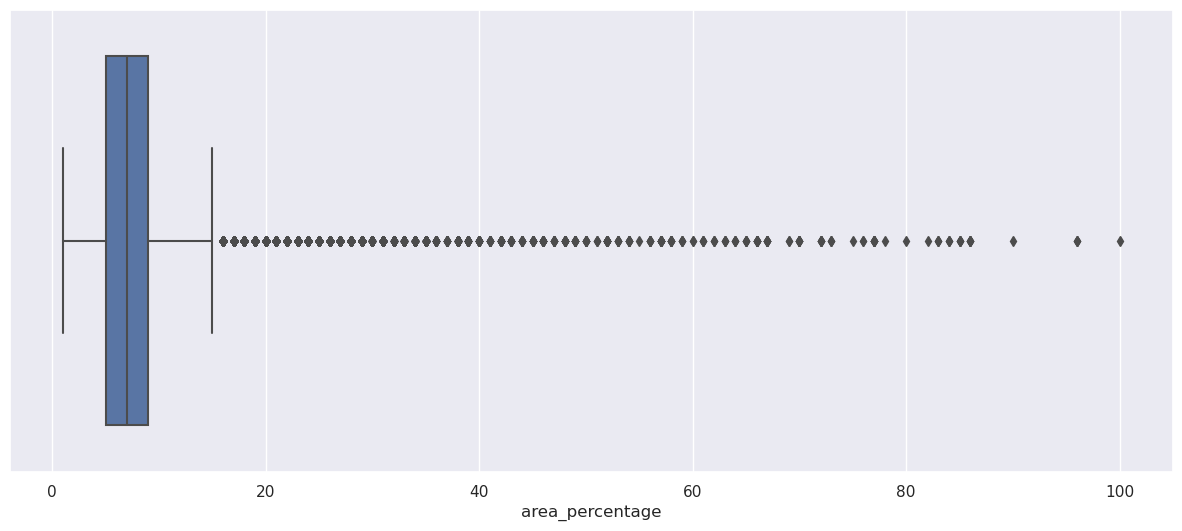

In [22]:
plt.figure(figsize=(15,6))
ax = sns.boxplot(x=train_df['area_percentage'])
plt.show()

Outliers are found from a value above 18

Text(0, 0.5, 'Count')

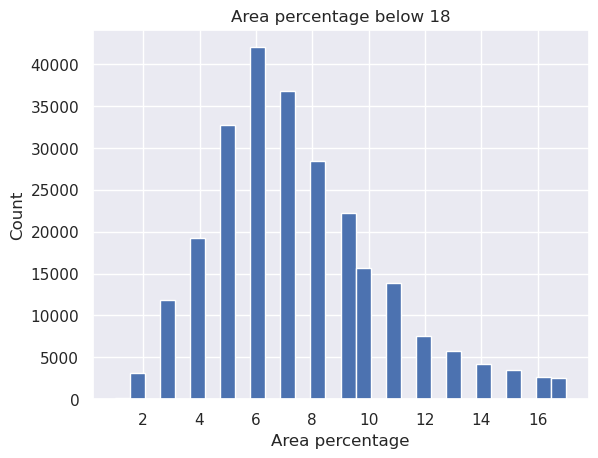

In [23]:
THRESHOLD = 18 

temp_df1 = train_df[train_df['area_percentage'] < THRESHOLD]
temp_df1['area_percentage'].hist(bins=30)
plt.title(f'Area percentage below {THRESHOLD}')
plt.xlabel('Area percentage')
plt.ylabel('Count')

Most of the buildings have an area_percentage between 5 and 9 

### Relation to target value

In [24]:
THRESHOLD = 18

merged_df = pd.merge(train_df, target_df, on='building_id')
temp_df1 = merged_df[['area_percentage', 'damage_grade']]
temp_df1 = temp_df1[merged_df['area_percentage'] < THRESHOLD]

corr_matrix = temp_df1.corr()
corr_matrix['damage_grade'].sort_values(ascending=False)

damage_grade       1.000000
area_percentage   -0.094628
Name: damage_grade, dtype: float64

Weak negative correlation, there is a tendency for buildings with higher area percentages to be less likely to have higher levels of damage. It is unlikely that area_percentage alone is a good predictor of damage_grade.

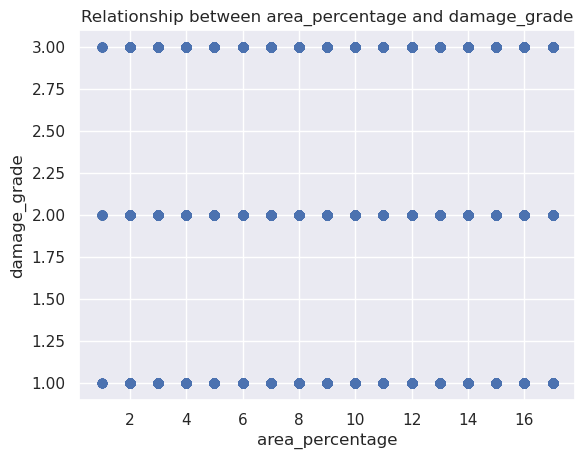

In [25]:
plt.scatter(temp_df1['area_percentage'], temp_df1['damage_grade'])
plt.title('Relationship between area_percentage and damage_grade')
plt.xlabel('area_percentage')
plt.ylabel('damage_grade')
plt.show()

Scatterplot shows weak correlation between area_percentage and damage_grade

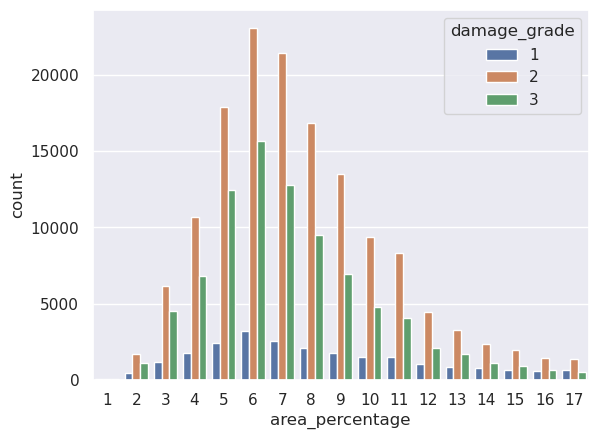

In [26]:
sns.countplot(x ='area_percentage', hue = 'damage_grade', data = temp_df1)
plt.show()

## 6. Analysis for `height_percentage`
Summary: DESCRIPTION UNSURE
The data contains many outliers above a value of 9. Most buildings have an height_percentage of 5. A correlation to the target value is almost nonexisting.


### Distribution

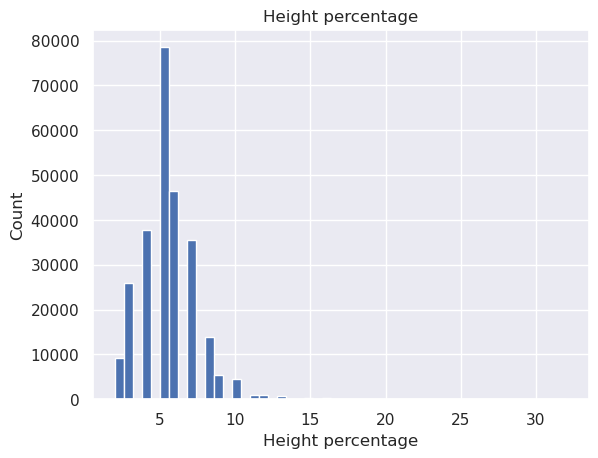

In [27]:
train_df['height_percentage'].hist(bins=50)
plt.title(f'Height percentage')
plt.xlabel('Height percentage')
plt.ylabel('Count')
plt.show()

The histogram is right-skewed, the data is not normally distributed.There may be outliers on the right side.

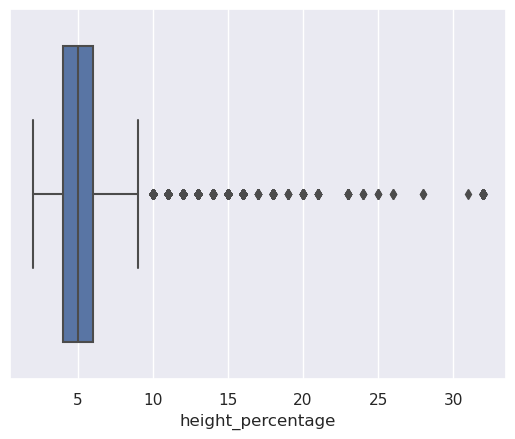

In [28]:
ax = sns.boxplot(x=train_df['height_percentage'])
plt.show()

Outliers are found from a value above 9

Text(0, 0.5, 'Count')

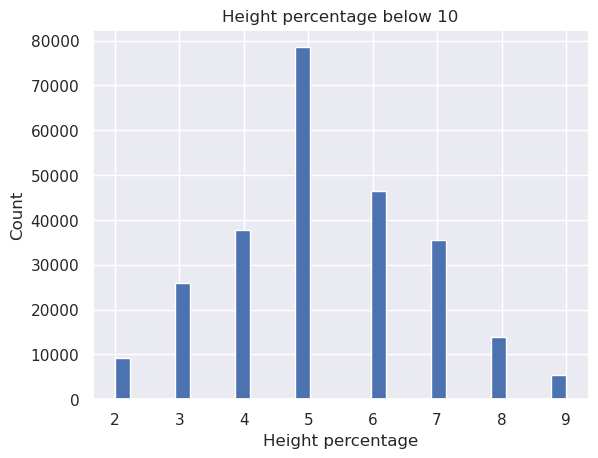

In [29]:
THRESHOLD = 10 

temp_df1 = train_df[train_df['height_percentage'] < THRESHOLD]
temp_df1['height_percentage'].hist(bins=30)
plt.title(f'Height percentage below {THRESHOLD}')
plt.xlabel('Height percentage')
plt.ylabel('Count')

Most of the buildings have an height_percentage of 5

### Relation to target value

In [30]:
THRESHOLD = 18

merged_df = pd.merge(train_df, target_df, on='building_id')
temp_df1 = merged_df[['height_percentage', 'damage_grade']]
temp_df1 = temp_df1[merged_df['height_percentage'] < THRESHOLD]

corr_matrix = temp_df1.corr()
corr_matrix['damage_grade'].sort_values(ascending=False)

damage_grade         1.000000
height_percentage    0.048194
Name: damage_grade, dtype: float64

Weak positive correlation, there is a tendency for buildings with higher height percentage to have higher damage.
It is unlikely that height_percentage alone is a good predictor of damage_grade.

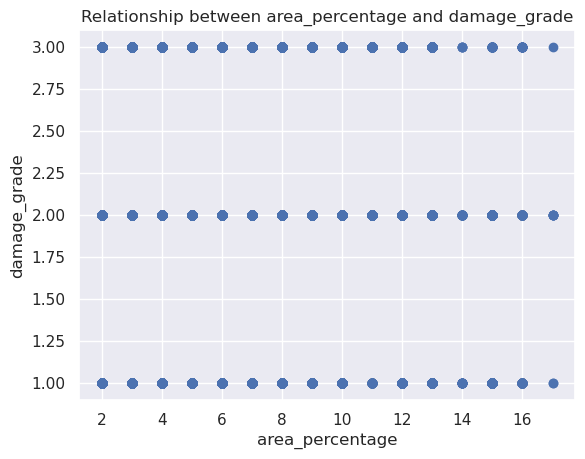

In [31]:
plt.scatter(temp_df1['height_percentage'], temp_df1['damage_grade'])
plt.title('Relationship between area_percentage and damage_grade')
plt.xlabel('area_percentage')
plt.ylabel('damage_grade')
plt.show()

Scatterplot shows weak correlation between height_percentage and damage_grade

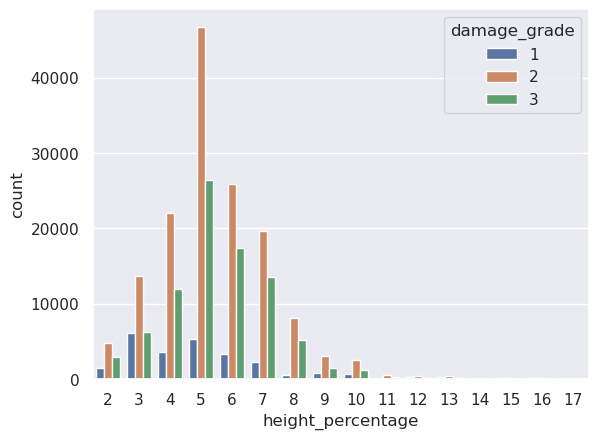

In [32]:
sns.countplot(x ='height_percentage', hue = 'damage_grade', data = temp_df1)
plt.show()

## 7. Analysis for `land_surface_condition`
Summary: The "land_surface_condition" feature describes the soil condition of the land using three categories:
"t" for tectonic soils,
"o" for other soils,
"n" for no special requirements for the soil condition. The feature is highly imbalanced. There is a significant relationship to the target

### Distribution

Possible Values are ['t' 'o' 'n']


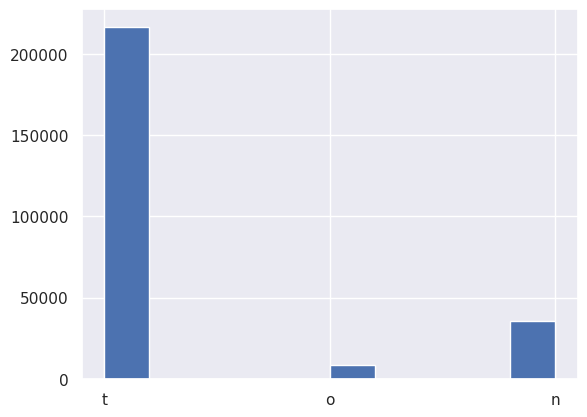

land_surface_condition
t    216757
n     35528
o      8316
Name: count, dtype: int64


In [33]:
print(f"Possible Values are { train_df['land_surface_condition'].unique()}")
train_df['land_surface_condition'].hist()
plt.show()
print(f"{train_df['land_surface_condition'].value_counts()}")

Most instances have the value 't', so most buildings were build on tectonic soils.

### Relation to the target value

<AxesSubplot:xlabel='land_surface_condition', ylabel='count'>

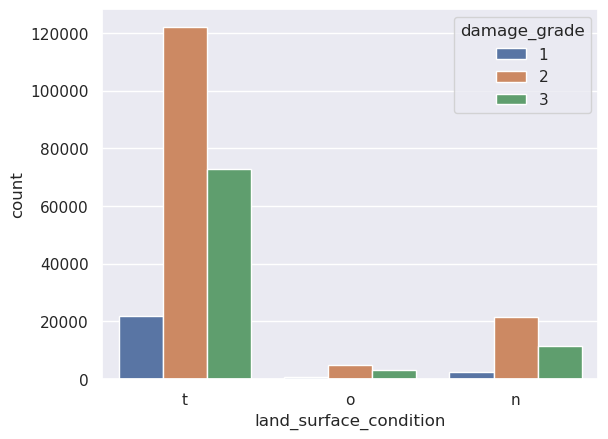

In [34]:
merged_df = pd.merge(train_df, target_df, on='building_id')
sns.countplot(x='land_surface_condition', hue='damage_grade', data=merged_df)

In [35]:
cross_tab = pd.crosstab(merged_df['land_surface_condition'], merged_df['damage_grade'])
chi2, pval, dof, exp_freq = chi2_contingency(cross_tab)

print("Chi-Square Test Statistik: ", chi2)
print("P-Value: ", pval)

Chi-Square Test Statistik:  449.6713606103201
P-Value:  5.115608104233124e-96


There is a significant relationship between the land_surface_condition and the damage_grade. The chi-square test statistic value of 449.67 and the very small P value of 5.12e-96 indicate that the result is very significant and we can reject the null hypothesis. This means that the categorical feature is likely to have an effect on the target.

## 8. Analysis for `foundation_type`
Summary: Describes the type of foundations on which buildings were built. The feature is highly imbalanced. Seems like there is a relation betweem foundation_type and damage_grade.

### Distribution

Possible values are ['r' 'w' 'i' 'u' 'h']


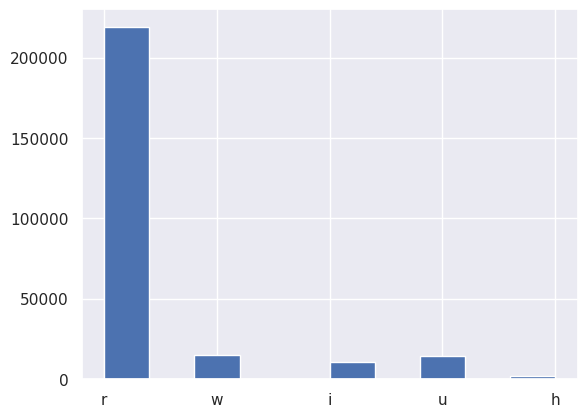

foundation_type
r    219196
w     15118
u     14260
i     10579
h      1448
Name: count, dtype: int64


In [36]:
print(f"Possible values are {train_df['foundation_type'].unique()}")
train_df['foundation_type'].hist()
plt.show()
print(f"{train_df['foundation_type'].value_counts()}")

foundation_type is highly imbalanced, 'r' is the most frequent value.

### Relation to the target value

<AxesSubplot:xlabel='foundation_type', ylabel='count'>

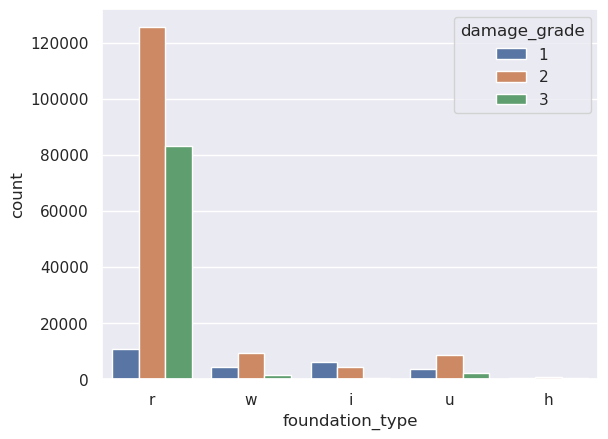

In [37]:
merged_df = pd.merge(train_df, target_df, on='building_id')
sns.countplot(x='foundation_type', hue='damage_grade', data=merged_df)

In [38]:
cross_tab = pd.crosstab(merged_df['foundation_type'], merged_df['damage_grade'])
chi2, pval, dof, exp_freq = chi2_contingency(cross_tab)

print("Chi-Square Test Statistik: ", chi2)
print("P-Value: ", pval)

Chi-Square Test Statistik:  48547.16073841265
P-Value:  0.0


There is a significant relationship between foundation_type and damage_grade. The null hypothesis that the variables are independent can be rejected.

## 9. Analysis for `roof_type`
Summary: Describes the type of the roof. The class is highly imbalanced. Seems like there is a relationship between roof_type and damage_grade.

### Distribution

Possible values are ['n' 'q' 'x']


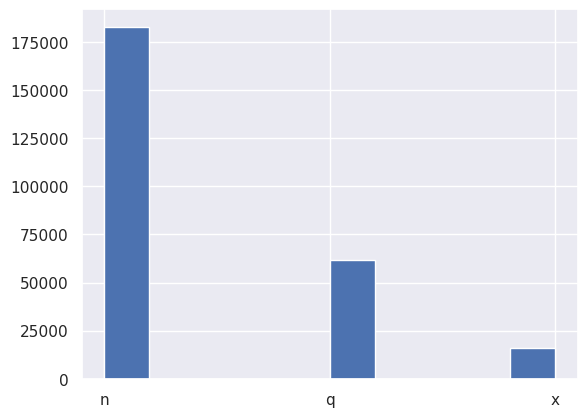

roof_type
n    182842
q     61576
x     16183
Name: count, dtype: int64


In [39]:
print(f"Possible values are {train_df['roof_type'].unique()}")
train_df['roof_type'].hist()
plt.show()
print(f"{train_df['roof_type'].value_counts()}")

roof_type is highly imbalanced, 'n' is the most frequent value

### Relation to the target value

<AxesSubplot:xlabel='roof_type', ylabel='count'>

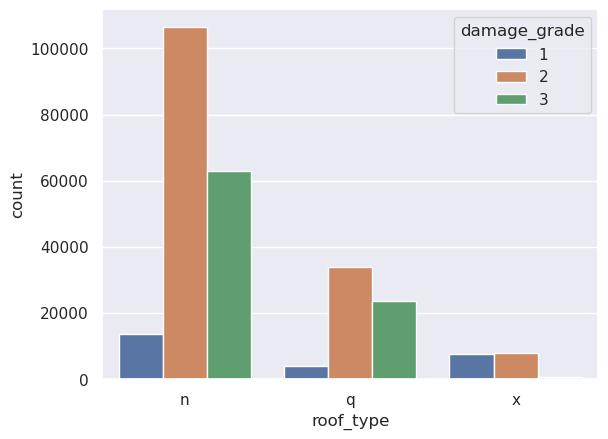

In [40]:
merged_df = pd.merge(train_df, target_df, on='building_id')
sns.countplot(x='roof_type', hue='damage_grade', data=merged_df)

In [41]:
cross_tab = pd.crosstab(merged_df['roof_type'], merged_df['damage_grade'])
chi2, pval, dof, exp_freq = chi2_contingency(cross_tab)

print("Chi-Square Test Statistik: ", chi2)
print("P-Value: ", pval)

Chi-Square Test Statistik:  30251.419274079504
P-Value:  0.0


Chi-square test shows that there is a significant relationship between the feature "roof_type" and the target "damage_grade".

## 10. Analysis for `ground_floor_type`
Summary: Describes the ground floor type. The class is highly imbalanced. There is a significant relationship between ground_floor_type and damage_grade.

### Distribution

Possible values are ['f' 'x' 'v' 'z' 'm']


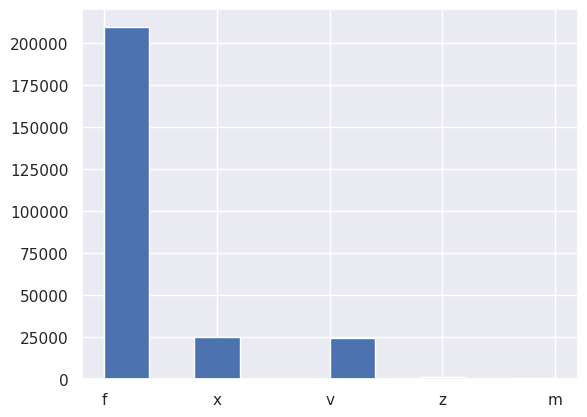

ground_floor_type
f    209619
x     24877
v     24593
z      1004
m       508
Name: count, dtype: int64


In [42]:
print(f"Possible values are {train_df['ground_floor_type'].unique()}")
train_df['ground_floor_type'].hist()
plt.show()
print(f"{train_df['ground_floor_type'].value_counts()}")

ground_floor_type is highly imbalanced, 'f' is the most frequent value

### Relation to the target value

<AxesSubplot:xlabel='ground_floor_type', ylabel='count'>

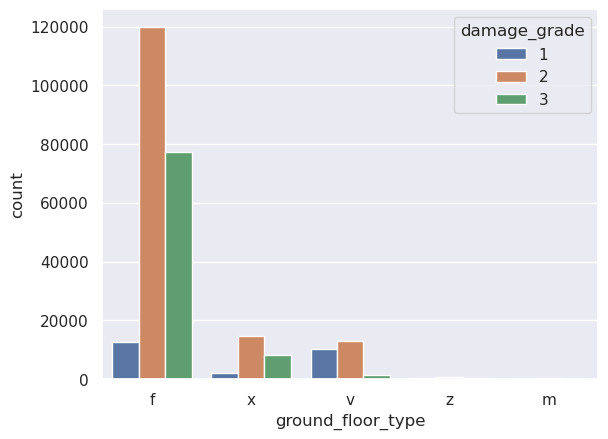

In [43]:
merged_df = pd.merge(train_df, target_df, on='building_id')
sns.countplot(x='ground_floor_type', hue='damage_grade', data=merged_df)

In [44]:
cross_tab = pd.crosstab(merged_df['ground_floor_type'], merged_df['damage_grade'])
chi2, pval, dof, exp_freq = chi2_contingency(cross_tab)

print("Chi-Square Test Statistik: ", chi2)
print("P-Value: ", pval)

Chi-Square Test Statistik:  36430.84896491971
P-Value:  0.0


The P value is very small (0.0), indicating that there is a significant relationship between ground_floor_type and damage_grade. The null hypothesis should be rejected.

## 11. Analysis for `other_floor_type`
Summary: Describes the other floor type. The class is highly imbalanced. There is a significant relationship between other_floor_type and damage_grade.

### Distribution

Possible values are ['q' 'x' 'j' 's']


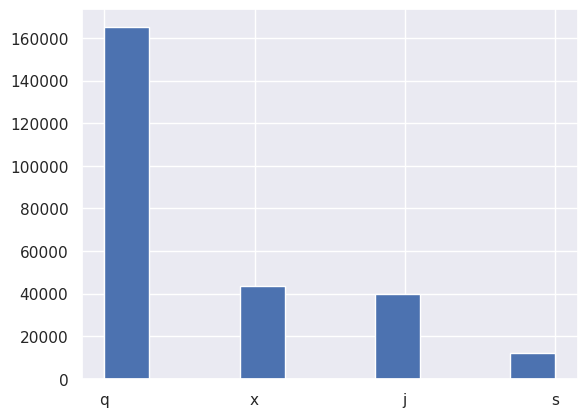

other_floor_type
q    165282
x     43448
j     39843
s     12028
Name: count, dtype: int64


In [45]:
print(f"Possible values are {train_df['other_floor_type'].unique()}")
train_df['other_floor_type'].hist()
plt.show()
print(f"{train_df['other_floor_type'].value_counts()}")

The class is highly imbalanced. The most frequent value is 'q'.

### Relation to the target value

<AxesSubplot:xlabel='other_floor_type', ylabel='count'>

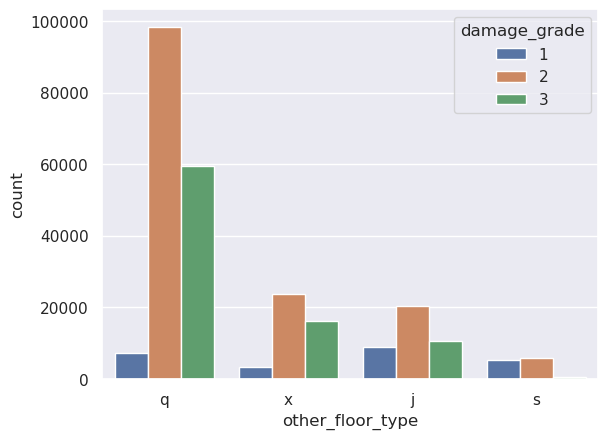

In [46]:
merged_df = pd.merge(train_df, target_df, on='building_id')
sns.countplot(x='other_floor_type', hue='damage_grade', data=merged_df)

In [47]:
cross_tab = pd.crosstab(merged_df['other_floor_type'], merged_df['damage_grade'])
chi2, pval, dof, exp_freq = chi2_contingency(cross_tab)

print("Chi-Square Test Statistik: ", chi2)
print("P-Value: ", pval)

Chi-Square Test Statistik:  31487.39192072909
P-Value:  0.0


There is a significant relationship between other_floor_type and damage_grade.

## 12. Analysis for `position`
Summary: DESCRIBTION UNSURE. The class is highly imbalanced. position and the damage_grade are significantly related in our dataset.

### Distribution

Possible values are ['t' 's' 'j' 'o']


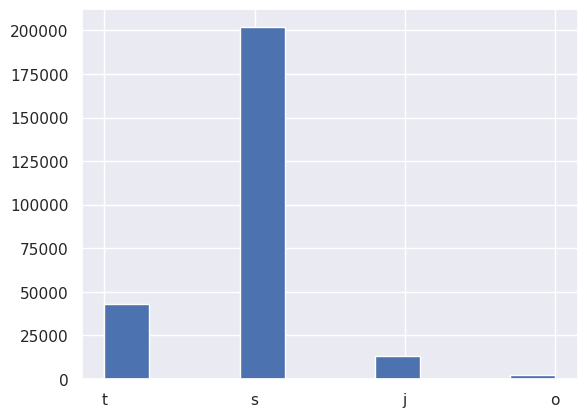

position
s    202090
t     42896
j     13282
o      2333
Name: count, dtype: int64


In [48]:
print(f"Possible values are {train_df['position'].unique()}")
train_df['position'].hist()
plt.show()
print(f"{train_df['position'].value_counts()}")

The class is highly imbalanced, the most frequent class is 's'.

### Relation to target value

<AxesSubplot:xlabel='position', ylabel='count'>

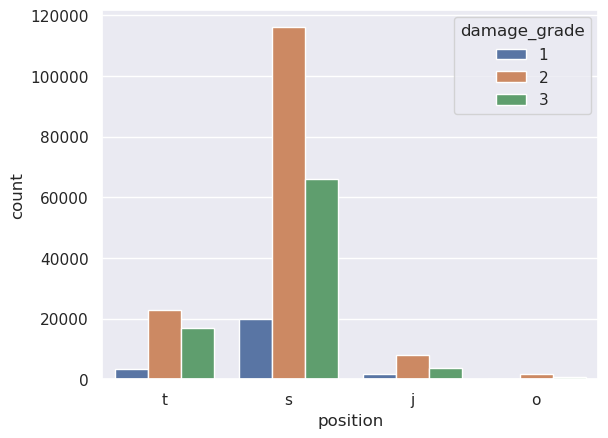

In [49]:
merged_df = pd.merge(train_df, target_df, on='building_id')
sns.countplot(x='position', hue='damage_grade', data=merged_df)

In [50]:
cross_tab = pd.crosstab(merged_df['position'], merged_df['damage_grade'])
chi2, pval, dof, exp_freq = chi2_contingency(cross_tab)

print("Chi-Square Test Statistik: ", chi2)
print("P-Value: ", pval)

Chi-Square Test Statistik:  1079.9274356300548
P-Value:  4.592452675444982e-230


The P-value is very low (4.59e-230), which means that it is extremely unlikely that this relationship is based on pure chance. Therefore, we can conclude that the feature and the target are significantly related in our dataset.

## 13.analysis for `plan_configuration`

`plan_configuration` seems to represent common classes of building structures and it is a multiclass categorical feature. It is highly imbalanced with the value `d` dominating all the others. The chi-square test shows a significant relationship to the target.

### Distribution

,value,count (abs),count (rel)
0,d,250072,95.96%
1,q,5692,2.18%
2,u,3649,1.40%
3,s,346,0.13%
4,c,325,0.12%
5,a,252,0.10%
6,o,159,0.06%
7,m,46,0.02%
8,n,38,0.01%
9,f,22,0.01%


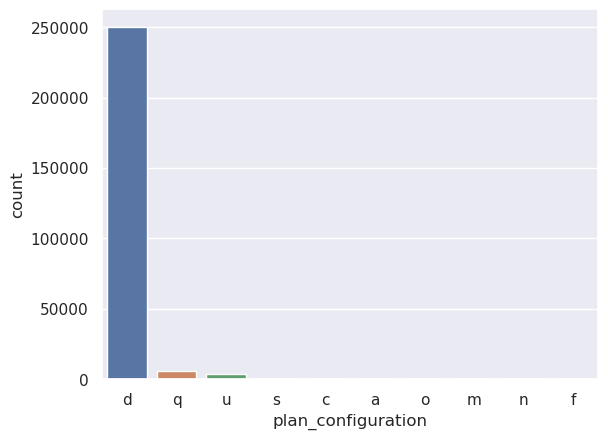

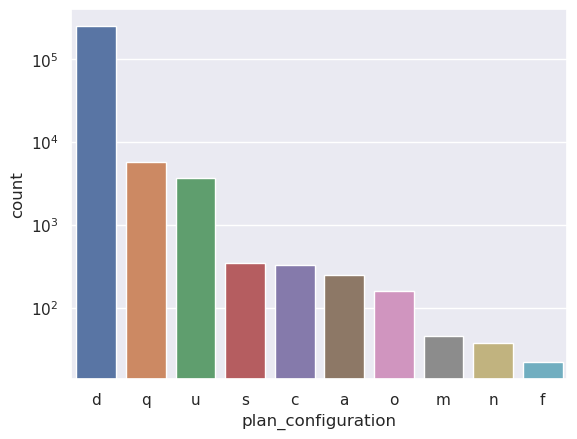

In [51]:
display(visualize.get_verbose_value_counts(train_df['plan_configuration']))

sns.countplot(data=train_df, x='plan_configuration', order=train_df['plan_configuration'].value_counts().index)
plt.show()

sns.countplot(data=train_df, x='plan_configuration', order=train_df['plan_configuration'].value_counts().index)
plt.yscale('log')
plt.show()

We see that `plan_configuration` is highly imbalanced with the value `d` dominating all other values and making up 95.96% of all configurations.

### Relation to the target value

Chi-Square Test Statistic:  1734.1171250474172
P-Value:  0.0


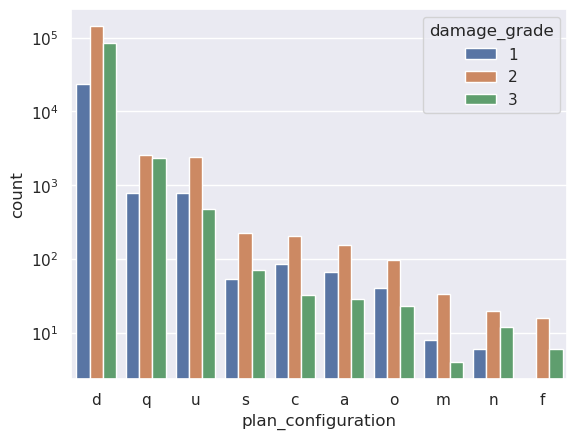

In [52]:
cross_tab = pd.crosstab(train_df['plan_configuration'], target_df['damage_grade'])
chi2, pval, dof, exp_freq = chi2_contingency(cross_tab)
print("Chi-Square Test Statistic: ", chi2)
print("P-Value: ", pval)

sns.countplot(
    data=train_df, 
    x='plan_configuration', 
    hue=target_df['damage_grade'], 
    order=train_df['plan_configuration'].value_counts().index
)
plt.yscale('log')
plt.show()

The chi-square test shows that there is a significant relationship between `plan_configuration` and the target `damage_grade` (p-value < 0.05).

## 14. analysis for `has_superstructure` features


The `has_superstructure` columns tell which superstructures are used in a building and they are binary categorical features. The most frequently used superstructures are mud-mortar-stone (76.19%) and timber (25.50%). 
Having a mud-mortar-stone superstructure has the biggest (absolute) correlation to the target with 0.291325, followed by cement-mortar-brick with -0.254131. `has_superstructure` features seem to be one of the more influental features regarding the target.

### Distribution

In [53]:
has_superstructure_columns = [
    'has_superstructure_adobe_mud',
    'has_superstructure_mud_mortar_stone', 
    'has_superstructure_stone_flag',
    'has_superstructure_cement_mortar_stone',
    'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick', 
    'has_superstructure_timber',
    'has_superstructure_bamboo', 
    'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered', 
    'has_superstructure_other'
]

has_superstructure_df = train_df[has_superstructure_columns]

,feature,occur. (abs),occur. (rel)
0,has_superstructure_mud_mortar_stone,198561,76.19%
1,has_superstructure_timber,66450,25.50%
2,has_superstructure_adobe_mud,23101,8.86%
3,has_superstructure_bamboo,22154,8.50%
4,has_superstructure_cement_mortar_brick,19615,7.53%
5,has_superstructure_mud_mortar_brick,17761,6.82%
6,has_superstructure_rc_non_engineered,11099,4.26%
7,has_superstructure_stone_flag,8947,3.43%
8,has_superstructure_cement_mortar_stone,4752,1.82%
9,has_superstructure_rc_engineered,4133,1.59%


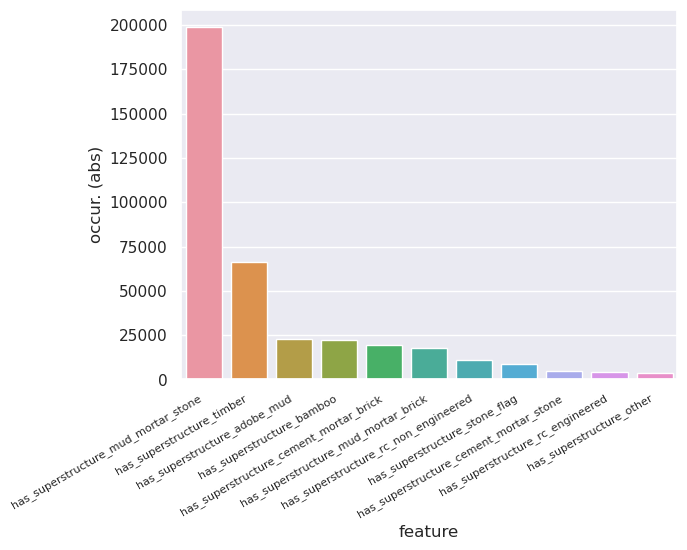

In [54]:
occurences = visualize.get_verbose_occurences(has_superstructure_df)

display(occurences)

sns.barplot(data=occurences, x='feature', y='occur. (abs)')
plt.xticks(rotation=30, fontsize=8, ha='right')
plt.show()

The vast majority of buildings have a mud-mortar-stone superstructure (76.19%). Another significantly often used superstructure is timber with 25.50% of all buildings.

### Relation to the target value

,feature_1,feature_2,corr.,corr. (abs.)
0,has_superstructure_mud_mortar_stone,damage_grade,0.291325,0.291325
1,has_superstructure_cement_mortar_brick,damage_grade,-0.254131,0.254131
2,has_superstructure_rc_engineered,damage_grade,-0.179014,0.179014
3,has_superstructure_rc_non_engineered,damage_grade,-0.158145,0.158145
4,has_superstructure_timber,damage_grade,-0.069852,0.069852
5,has_superstructure_stone_flag,damage_grade,0.066039,0.066039
6,has_superstructure_bamboo,damage_grade,-0.063051,0.063051
7,has_superstructure_cement_mortar_stone,damage_grade,-0.060295,0.060295
8,has_superstructure_adobe_mud,damage_grade,0.055314,0.055314
9,has_superstructure_other,damage_grade,-0.030224,0.030224


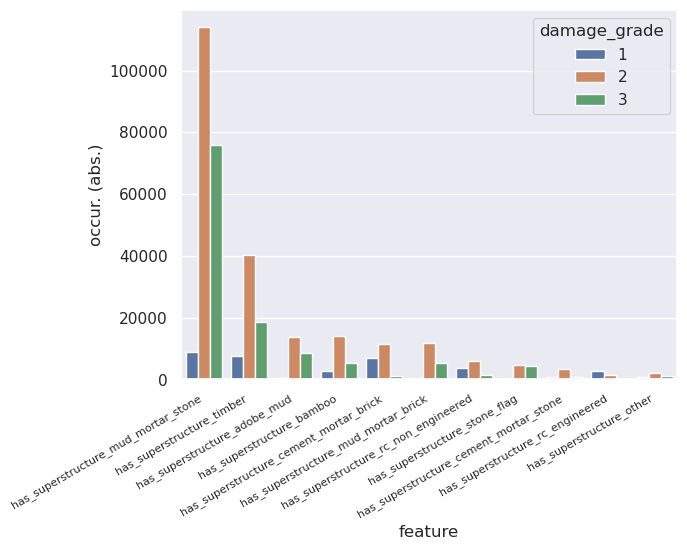

In [55]:
df = pd.merge(train_df, target_df, on='building_id', how='outer')
display(visualize.get_verbose_correlations(df, has_superstructure_columns, ['damage_grade']))

df = df[has_superstructure_columns + ['damage_grade']].groupby('damage_grade').sum()
df = df[df.sum().sort_values(ascending=False).index]
df = df.reset_index().melt(id_vars=['damage_grade'])

sns.barplot(data=df, x='variable', y='value', hue='damage_grade')
plt.xticks(rotation=30, fontsize=8, ha='right')
plt.xlabel('feature')
plt.ylabel('occur. (abs.)')
plt.show()

Whether mud-mortar-stone is used as a superstructure has the highest influence on the damage grade with a correlation of 0.291325. The use of this type of superstructure correlates with a higher damage grade. Another significant superstructure is cement-mortar-brick with a correlation of -0.254131. Their use correlates with a lower damage grade. Also influental are whether buildings have rc-engineered (-0.179014) and rc-non-engineered (-0.158145) superstructures. All in all, the used superstructures seem to be one of the more important features regarding the target.


## 15. analysis for `legal_ownership_status`

`legal_ownership_status` seems to tell who owns the building and it is a multiclass categorical feature. It is higly imbalanced with almost all values being `v` (96.29%). The chi-square test shows a significant relationship to the target.

### Distribution

,value,count (abs),count (rel)
0,v,250939,96.29%
1,a,5512,2.12%
2,w,2677,1.03%
3,r,1473,0.57%


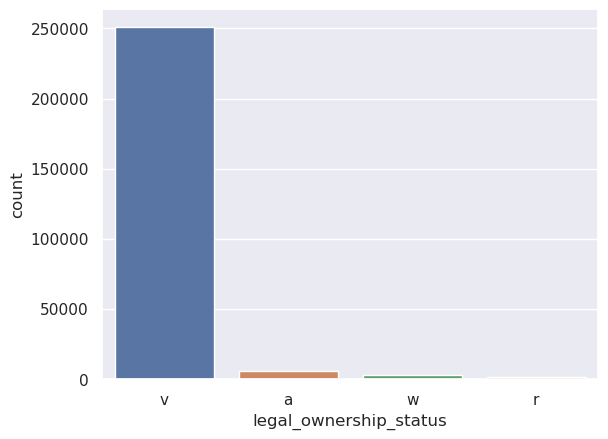

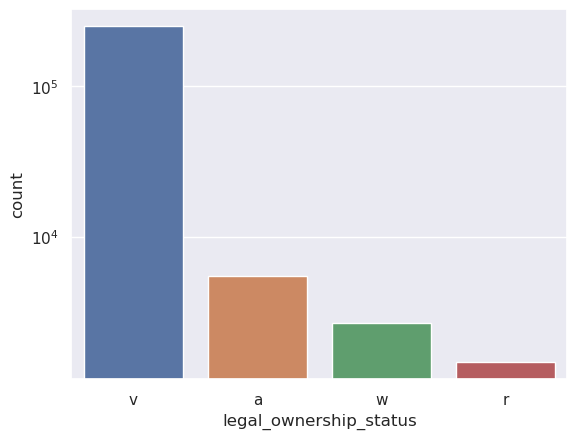

In [56]:
display(visualize.get_verbose_value_counts(train_df['legal_ownership_status']))

sns.countplot(data=train_df, x='legal_ownership_status', order=train_df['legal_ownership_status'].value_counts().index)
plt.show()

sns.countplot(data=train_df, x='legal_ownership_status', order=train_df['legal_ownership_status'].value_counts().index)
plt.yscale('log')
plt.show()

We see that `legal_ownership_status` is highly imbalanced with the value `v` dominating all other values (96.29%).

### Relation to the target value

Chi-Square Test Statistic:  2586.162841474136
P-Value:  0.0


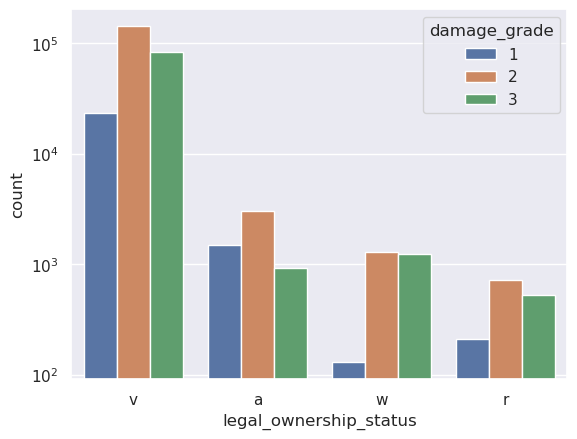

In [57]:
cross_tab = pd.crosstab(train_df['legal_ownership_status'], target_df['damage_grade'])
chi2, pval, dof, exp_freq = chi2_contingency(cross_tab)
print("Chi-Square Test Statistic: ", chi2)
print("P-Value: ", pval)

sns.countplot(
    data=train_df, 
    x='legal_ownership_status', 
    hue=target_df['damage_grade'], 
    order=train_df['legal_ownership_status'].value_counts().index
)
plt.yscale('log')
plt.show()

The chi-square test shows a significant relationship between `legal_ownership_status` and the target `damage_grade` (p-value < 0.05).


## 16. analysis for `count_families`

`count_families` seems to tell how many families live in the building and it is a numeric feature. The vast majority of buildings have one family living in them (86.77%). There is small positive correlation between more families in a building and a higher damage grade (0.056151).

### Distribution

,value,count (abs),count (rel)
0,1,226115,86.77%
1,0,20862,8.01%
2,2,11294,4.33%
3,3,1802,0.69%
4,4,389,0.15%
5,5,104,0.04%
6,6,22,0.01%
7,7,7,0.00%
8,9,4,0.00%
9,8,2,0.00%


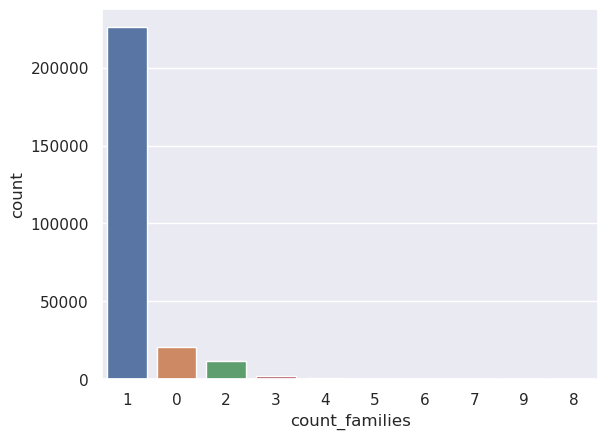

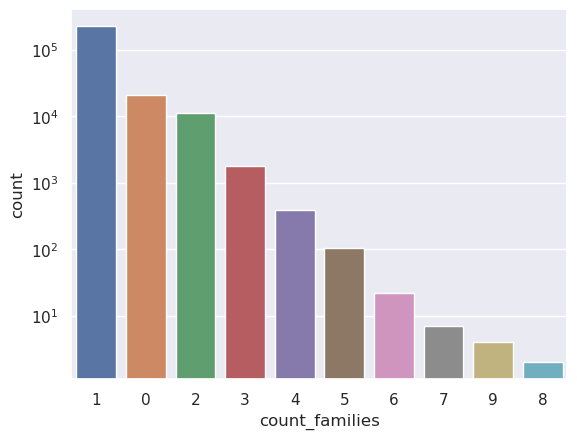

In [58]:
display(visualize.get_verbose_value_counts(train_df['count_families']))

sns.countplot(data=train_df, x='count_families', order=train_df['count_families'].value_counts().index)
plt.show()

sns.countplot(data=train_df, x='count_families', order=train_df['count_families'].value_counts().index)
plt.yscale('log')
plt.show()

The vast majority of buildings have one family living in them (86.77%), while buildings with no family make up 8.01% and two-family buildings make up 4.33%.

### Relation to the target value

,feature_1,feature_2,corr.,corr. (abs.)
0,count_families,damage_grade,0.056151,0.056151


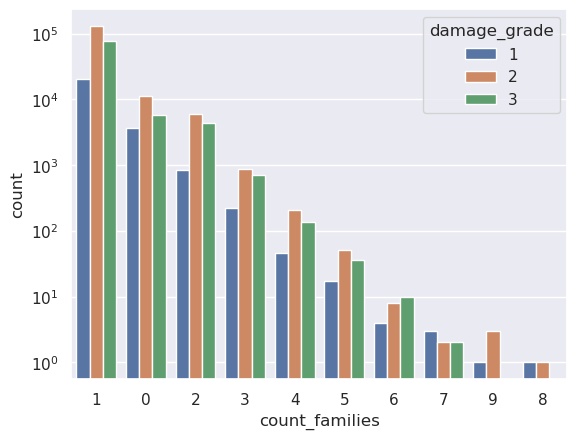

In [59]:
df = pd.merge(train_df, target_df, on='building_id', how='outer')
display(visualize.get_verbose_correlations(df, ['count_families'], ['damage_grade']))

sns.countplot(
    data=train_df, 
    x='count_families', 
    hue=target_df['damage_grade'], 
    order=train_df['count_families'].value_counts().index
)
plt.yscale('log')
plt.show()

There is a small correlation between more families living in a building and a higher damage grade (0.056151).


## 17. analysis for `has_secondary_use` features

`has_secondary_use` columns tell what kind of secondary use a building has and they are binary categorical features. The vast majority of buildings do not have a secondary use (88.81%). The ones that have a secondary use, are mostly in agriculture (6.44%) and as a hotel (3.36%). Having a secondary use has a small negative correlation with the target, i.e., a secondary use correlates with a smaller damage grade.

### Distribution

The `has_secondary_use` feature tells whether there is a secondary use or not, so we will examine it separate from the other features.

In [60]:
visualize.get_verbose_value_counts(train_df['has_secondary_use'])

,value,count (abs),count (rel)
0,0,231445,88.81%
1,1,29156,11.19%


The vast majority of buildings do not have a secondary use. For those that do, let us examine which secondary uses they are.

In [61]:
has_secondary_use_columns = [
    'has_secondary_use_agriculture', 
    'has_secondary_use_hotel',
    'has_secondary_use_rental', 
    'has_secondary_use_institution',
    'has_secondary_use_school', 
    'has_secondary_use_industry',
    'has_secondary_use_health_post', 
    'has_secondary_use_gov_office',
    'has_secondary_use_use_police', 
    'has_secondary_use_other'
]

has_secondary_use_df = train_df[has_secondary_use_columns]

,feature,occur. (abs),occur. (rel)
0,has_secondary_use_agriculture,16777,6.44%
1,has_secondary_use_hotel,8763,3.36%
2,has_secondary_use_rental,2111,0.81%
3,has_secondary_use_other,1334,0.51%
4,has_secondary_use_industry,279,0.11%
5,has_secondary_use_institution,245,0.09%
6,has_secondary_use_school,94,0.04%
7,has_secondary_use_health_post,49,0.02%
8,has_secondary_use_gov_office,38,0.01%
9,has_secondary_use_use_police,23,0.01%


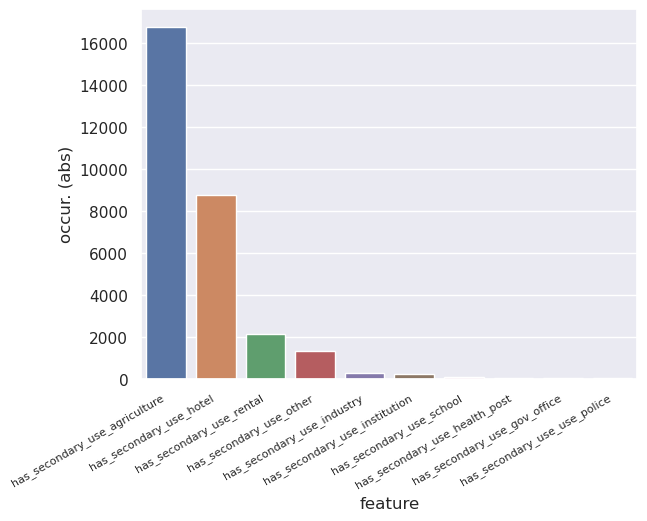

In [62]:
occurences = visualize.get_verbose_occurences(has_secondary_use_df)

display(occurences)

sns.barplot(data=occurences, x='feature', y='occur. (abs)')
plt.xticks(rotation=30, fontsize=8, ha='right')
plt.show()

The most frequent secondary use is in agriculture, followed by use as a hotel. Uses as police building, government office, health post, school, institution and in industry are rare.

### Relation to the target value

Let us first examine the relationship between the `has_secondary_use` feature and the target.

In [63]:
df = pd.merge(train_df, target_df, on='building_id', how='outer')
display(visualize.get_verbose_correlations(df, ['has_secondary_use'], ['damage_grade']))

,feature_1,feature_2,corr.,corr. (abs.)
0,has_secondary_use,damage_grade,-0.07963,0.07963


There is a small negative correlation (-0.07963) between a building having a secondary use and the damage grade. So, having a secondary use makes it more likely that the building was not damaged as much. Let us look at the secondary uses in detail.

,feature_1,feature_2,corr.,corr. (abs.)
0,has_secondary_use_hotel,damage_grade,-0.097942,0.097942
1,has_secondary_use_rental,damage_grade,-0.083754,0.083754
2,has_secondary_use_institution,damage_grade,-0.028728,0.028728
3,has_secondary_use_other,damage_grade,-0.016334,0.016334
4,has_secondary_use_school,damage_grade,-0.011692,0.011692
5,has_secondary_use_agriculture,damage_grade,0.011309,0.011309
6,has_secondary_use_industry,damage_grade,-0.011024,0.011024
7,has_secondary_use_gov_office,damage_grade,-0.009378,0.009378
8,has_secondary_use_health_post,damage_grade,-0.008543,0.008543
9,has_secondary_use_use_police,damage_grade,-0.001656,0.001656


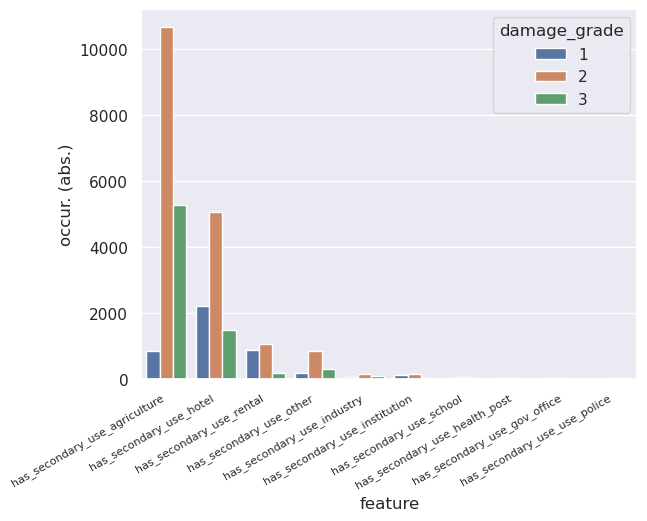

In [64]:
df = pd.merge(train_df, target_df, on='building_id', how='outer')
display(visualize.get_verbose_correlations(df, has_secondary_use_columns, ['damage_grade']))

df = df[has_secondary_use_columns + ['damage_grade']].groupby('damage_grade').sum()
df = df[df.sum().sort_values(ascending=False).index]
df = df.reset_index().melt(id_vars=['damage_grade'])

sns.barplot(data=df, x='variable', y='value', hue='damage_grade')
plt.xticks(rotation=30, fontsize=8, ha='right')
plt.xlabel('feature')
plt.ylabel('occur. (abs.)')
plt.show()

The secondary use as a hotel (-0.097942) and as a rental (-0.083754) have the highest (absolute) correlation to the target. A secondary use as a hotel or rental correlates with a lower damage grade.

## Analysis of target value
---

Let us examine the target.

In [65]:
target_df.head(10)

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
5,333020,2
6,728451,3
7,475515,1
8,441126,2
9,989500,1


In [66]:
display(visualize.get_verbose_value_counts(target_df['damage_grade']))

,value,count (abs),count (rel)
0,2,148259,56.89%
1,3,87218,33.47%
2,1,25124,9.64%


First off, there are three different damage_grades. Furthermore, we observe that the target is higly imbalanced with the medium damage grade occuring the most frequent (56.89%).

### Analysis of missing and default values, as well as finding uninformative columns
---

Let us examine if there are any missing values (NaN) and if there are duplicate rows.

In [67]:
print('missing values:', train_df.isnull().values.any())
print('duplicate rows:', train_df.duplicated().any())

missing values: False
duplicate rows: False


Regarding uninformative columns, our analysis up to now has shown that there are a couple of highly imbalanced features with values occuring in more than 90% of times. Furthermore, we have the feature `building_id` that is a unique identifier for each sample and therefore can be dropped as it is not useful in classification. Another uninformative column is `has_secondary_use`, as whether a building has a secondary feature or not is already given by the values of the other `has_secondary_use` features.

### Analysis of relationships between features
---

#### Relationsships between features

We split this analysis between multiclass categorical and numerical features. First, we examine the relations between the categorical features with a chi-square test.

In [68]:
multiclass_columns = train_df.select_dtypes(include=[object]).columns

statistics = visualize.get_verbose_chi_square_statistics(
    train_df, 
    multiclass_columns.tolist(),
    multiclass_columns.tolist()
)

In [69]:
display(statistics)

,feature_1,feature_2,statistic,p-value
0,foundation_type,roof_type,156385.835057,0.000000e+00
1,roof_type,other_floor_type,142044.013102,0.000000e+00
2,foundation_type,ground_floor_type,132225.382815,0.000000e+00
3,foundation_type,other_floor_type,131881.145478,0.000000e+00
4,roof_type,ground_floor_type,116144.743961,0.000000e+00
5,ground_floor_type,other_floor_type,103392.745730,0.000000e+00
6,foundation_type,legal_ownership_status,17642.981291,0.000000e+00
7,other_floor_type,position,9905.431744,0.000000e+00
8,roof_type,position,8258.213905,0.000000e+00
9,foundation_type,position,7580.355830,0.000000e+00


Our chi-square tests are significant between all categorical columns, as all p-values are smaller than 0.05. This implies that all of these features are related. We think that there the chi-square test does not work properly for such a large number of samples. For the next step, we will examine the relations between numerical features with the correlation coefficient.

In [70]:
not_multiclass_columns = train_df.select_dtypes(exclude=[object]).columns

correlations = visualize.get_verbose_correlations(
    train_df, 
    not_multiclass_columns.tolist(), 
    not_multiclass_columns.tolist()
)

In [71]:
display(correlations.head(25))
display(correlations.tail(25))

,feature_1,feature_2,corr.,corr. (abs.)
0,count_floors_pre_eq,height_percentage,0.778430,0.778430
1,has_secondary_use,has_secondary_use_agriculture,0.739059,0.739059
2,has_secondary_use,has_secondary_use_hotel,0.525564,0.525564
3,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,-0.470715,0.470715
4,has_superstructure_timber,has_superstructure_bamboo,0.438311,0.438311
5,has_superstructure_mud_mortar_stone,has_superstructure_mud_mortar_brick,-0.376208,0.376208
6,has_superstructure_adobe_mud,has_superstructure_mud_mortar_brick,0.314979,0.314979
7,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,-0.306861,0.306861
8,count_floors_pre_eq,has_superstructure_mud_mortar_brick,0.257279,0.257279
9,has_secondary_use,has_secondary_use_rental,0.254614,0.254614


,feature_1,feature_2,corr.,corr. (abs.)
440,has_secondary_use_institution,has_secondary_use_health_post,-0.000421,0.000421
441,has_secondary_use_industry,has_secondary_use_gov_office,-0.000395,0.000395
442,building_id,geo_level_3_id,-0.000394,0.000394
443,has_secondary_use_institution,has_secondary_use_gov_office,-0.000370,0.000370
444,building_id,has_secondary_use_health_post,-0.000368,0.000368
445,building_id,has_secondary_use_school,-0.000360,0.000360
446,building_id,geo_level_2_id,0.000344,0.000344
447,has_superstructure_mud_mortar_brick,has_secondary_use_school,-0.000326,0.000326
448,building_id,has_superstructure_adobe_mud,-0.000311,0.000311
449,has_secondary_use_industry,has_secondary_use_use_police,-0.000308,0.000308


We observe the highest correlation between `count_floors_pre_eq` and `height_percentage`, so a high floor count strongly correlates with height percentage. Also, `has_secondary_use` is higly correlated with other `has_secondary_use` features which is not surprising. We find strong negative correlations between the use of mud-mortar-stone and mud-mortar-brick and cement-mortar brick. Their use seems to be mostly mutually exclusive. Also, timber and bamboo is often used together. 
Regarding low correlations, we observe that `building_id` has a very low absolute correlation with a lot of features. This is not surprising, as it is an id column and unique for every row.
Finally, we evalute the relationships between the numeric and categorical features with ANOVA tests.

In [72]:
multiclass_columns = train_df.select_dtypes(include=[object]).columns
not_multiclass_columns = train_df.select_dtypes(exclude=[object]).columns

statistics = visualize.get_verbose_anova_statistics(
    train_df, 
    multiclass_columns.tolist(),
    not_multiclass_columns.tolist()
)

In [73]:
display(statistics.head(25))
display(statistics.tail(25))

,feature_1,feature_2,statistic,p-value
0,other_floor_type,count_floors_pre_eq,70095.679334,0.0
1,other_floor_type,height_percentage,47645.395490,0.0
2,roof_type,has_superstructure_rc_engineered,36319.043190,0.0
3,ground_floor_type,has_superstructure_cement_mortar_brick,34146.292116,0.0
4,roof_type,has_superstructure_rc_non_engineered,32355.985795,0.0
5,roof_type,has_superstructure_mud_mortar_stone,30947.881714,0.0
6,foundation_type,has_superstructure_mud_mortar_stone,28643.752436,0.0
7,roof_type,has_superstructure_cement_mortar_brick,27919.335249,0.0
8,foundation_type,has_superstructure_rc_engineered,27223.368497,0.0
9,foundation_type,has_superstructure_cement_mortar_brick,23015.719230,0.0


,feature_1,feature_2,statistic,p-value
223,land_surface_condition,has_secondary_use_school,2.976648,0.050965
224,plan_configuration,geo_level_3_id,2.921349,0.001830
225,legal_ownership_status,has_secondary_use_industry,2.473122,0.059669
226,land_surface_condition,building_id,2.111079,0.121109
227,plan_configuration,has_secondary_use_industry,1.715981,0.079450
228,position,building_id,1.704004,0.163779
229,ground_floor_type,building_id,1.426621,0.222170
230,land_surface_condition,has_secondary_use_use_police,1.309571,0.269938
231,plan_configuration,has_secondary_use_health_post,0.953621,0.476664
232,legal_ownership_status,building_id,0.926747,0.426764


As with the chi-square test, we see that most features have a signficiant correlation to each other, as the p-value is lower than 0.05. What is more interesting, is that we actually have feature relations where the test shows that they are not related. For example, `has_secondary_use_gov_office` is statistically independent from `legal_ownership_states` and `plan_configuration`. Another interesting observation is that `building_id` is statistically independent from many other features. Again this is not surprising, as it is an id column.

#### Analysis of potential one-hot encodings
The dataset seems to contain features whose values are mutually exclusive. These are the `has_superstructure` features and the `has_secondary_use` features to be exact. We assume that they might be the results of one-hot encodings. Let us examine this.

In [74]:
has_superstructure_columns = [
    'has_superstructure_adobe_mud',
    'has_superstructure_mud_mortar_stone', 
    'has_superstructure_stone_flag',
    'has_superstructure_cement_mortar_stone',
    'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick', 
    'has_superstructure_timber',
    'has_superstructure_bamboo', 
    'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered', 
    'has_superstructure_other'
]

train_df[has_superstructure_columns].head(10)

,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other
0,1,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,1,1,0,0,0,0
8,0,1,0,0,0,0,1,0,0,0,0
9,0,0,0,0,0,1,0,0,0,0,0


In [75]:
print('train_df[has_superstructure_columns] is one-hot encoded:', build_features.is_one_hot_encoded(train_df[has_superstructure_columns]))

train_df[has_superstructure_columns] is one-hot encoded: False


We see in the first sample, that the features `has_superstructure_adobe_mud` and `has_superstructure_mud_mortar_stone` both have the value 1. Therefore, our assumption that the `has_superstructure` features are one-hot encoded is false. This observation is supported by the result of the `is_one_hot_encoded` operation that checks whether each row contains exactly one 1 with the rest being 0. In conclusion, a building can have multiple superstructures.

In [76]:
has_secondary_use_columns = [
    'has_secondary_use',
    'has_secondary_use_agriculture', 
    'has_secondary_use_hotel',
    'has_secondary_use_rental', 
    'has_secondary_use_institution',
    'has_secondary_use_school', 
    'has_secondary_use_industry',
    'has_secondary_use_health_post', 
    'has_secondary_use_gov_office',
    'has_secondary_use_use_police', 
    'has_secondary_use_other'
]

train_df[has_secondary_use_columns].head(10)

,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
5,1,1,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0


We observe in the first sample, that there is not a single occurence of 1. Furthermore, in the sixth sample both `has_secondary_use` and `has_secondary_use_agriculture` are both 1. From this we could conclude, that this also is not a one-hot encoding. But we also observe, that `has_secondary_use` only is 1 if one of the other values is 1. Let us replace this feature with its complement `has_no_secondary_use`. The information in the dataset stays the same.

In [77]:
has_secondary_use_df = pd.DataFrame(train_df[has_secondary_use_columns])

has_secondary_use_df['has_no_secondary_use'] = has_secondary_use_df['has_secondary_use'].replace({0:1, 1:0})
has_secondary_use_df = has_secondary_use_df.drop(columns=['has_secondary_use'])

has_secondary_use_df.head(10)

,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,has_no_secondary_use
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1
5,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,1


In [78]:
print('has_secondary_use_df is one-hot encoded:', build_features.is_one_hot_encoded(has_secondary_use_df))

has_secondary_use_df is one-hot encoded: False


Although the presented section of the dataframe shows a one-hot encoding, our `is_one_hot_encoded` function returns that the whole dataframe is not one-hot encoded. Let us examine the rows where this is not the case.

In [79]:
not_one_hot_encoded_rows = has_secondary_use_df[has_secondary_use_df.sum(axis=1) >= 2]

print('number of not one-hot encoded rows:', len(not_one_hot_encoded_rows))
print('values of', not_one_hot_encoded_rows['has_secondary_use_other'].value_counts())
not_one_hot_encoded_rows.head(10)

number of not one-hot encoded rows: 557
values of has_secondary_use_other
1    557
Name: count, dtype: int64


,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,has_no_secondary_use
304,1,0,0,0,0,0,0,0,0,1,0
1408,1,0,0,0,0,0,0,0,0,1,0
1593,1,0,0,0,0,0,0,0,0,1,0
2329,1,0,0,0,0,0,0,0,0,1,0
3704,0,1,0,0,0,0,0,0,0,1,0
4662,1,0,0,0,0,0,0,0,0,1,0
4785,1,0,0,0,0,0,0,0,0,1,0
4972,1,0,0,0,0,0,0,0,0,1,0
5002,1,0,0,0,0,0,0,0,0,1,0
5359,1,0,0,0,0,0,0,0,0,1,0


We see, that the rows that are not one-hot encoded always have the flag `has_secondary_use_other` set to 1, while the remaining features represent a valid one-hot encoding. In later preprocessing steps, we could think about ignoring the `has_secondary_use_other` flag for these rows (i.e. setting it to 0) and decode this otherwise valid one-hot encoding.